In [3]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
import time
from tqdm import trange
from stardate.lhf import gk_rotation_model
import stardate
from itertools import product

mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

def genErr(dv, dv_err):
    errorRand=np.random.normal(0, 1, len(dv))
    return dv+dv_err*errorRand


# get average ages
def getAveAges(df,fs,binfs,vz='v_b'):
    min_star=15
    max_star=30
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """        
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    iso_age=df['iso_age'].values
    iso_age_err=df['iso_age_err1'].values
    
    iso_ave=np.zeros(len(df))
    iso_ave_err=np.zeros(len(df))
    
    vels=df[vz].values
    kin_age=np.zeros(len(df))
            
            
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        binfs_new=binfs
        while sum(mask)<min_star:
            if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*1.1 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            
            
        iso_age_single=iso_age[mask]
        iso_age_err_single=iso_age_err[mask]
        
        weights=1/np.power(iso_age_err_single,2)
        iso_ave[i]=sum((iso_age_single*weights)/sum(weights))
        iso_ave_err[i]=np.std(iso_age_err_single)
        
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['iso_age_ave']=iso_ave
    df['iso_age_ave_err']=iso_ave_err
    return v_to_age(kin_age,p_a),iso_ave,iso_ave_err

import time
from tqdm import trange
# get average ages
def getkinAges(df,fs,binfs,min_star=5,max_star=30,vz='v_b'):
    countsNo=0
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """        
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    vels=df[vz].values
    kin_age=np.zeros(len(df))
        

    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        vels_single=vels[mask]
        
        binfs_new=binfs
        switch=0
        while len(vels_single)<min_star:
            if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*1.1 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            switch=1
            
        while len(vels_single)>max_star:
            if any([binfs_new[jj]<binfs[jj]/2 for jj in range(len(binfs))]):
                    break
            binfs_new=[i*0.9 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            switch=1
            
        if switch==1:
            countsNo=countsNo+1
        
                
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
                
                
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['kin_age']=v_to_age(kin_age,p_a)
    print(countsNo)
    return kin_age,v_to_age(kin_age,p_a)

    

# get average ages
def getkinAges_err(df,fs,fs_err,binfs,min_star=5,max_star=30,sampsize=50,vz='v_b',vz_err='v_b_err'):
    # generate new data
    newDatas=np.zeros((len(df),len(fs),sampsize))
    
    ages=np.zeros((len(df),sampsize))
    
    for i in range(len(fs)):
        if 'Prot' in fs[i]:
            newDatas[:,i,:]=np.log10(getErr(df[fs[i]],df[fs_err[i]],sampsize))
        else:
            newDatas[:,i,:]=getErr(df[fs[i]],df[fs_err[i]],sampsize)
    
    # generate new vb data
    newVbs=np.zeros((len(df),sampsize))
    newVbs=getErr(df[vz],df[vz+'_err'],sampsize)
    
    newfs=[i+'_new' for i in fs]
    for i in range(sampsize):
        print(i/sampsize)
        for j in range(len(fs)):
            df[newfs[j]]=newDatas[:,j,i]
        df[vz+'_new']=newVbs[:,i]
        _,ages[:,i]=getkinAges(df,newfs,binfs,vz=vz+'_new',min_star=min_star)
    return ages




def getVs(px,pmra,pmdec,ra,dec):
    """ Calculates tangential velocity (v_tan) and vertical velocity proximation (v_b).
    
    Args:
      df ([Pandas DataFrame]): DataFrame contains columns 'parallax', 'pmra', 'pmdec', 'ra', 'dec', which are parallax, ra proper motion, dec propermotion, right ascension and declination, respectively  
    
    Returns:
      :v_t ([array-like]): Tangential velocity
      :v_b ([array-like]): Proxy for vertical velocity
    """
    d = coord.Distance(parallax=np.array(px) * u.mas,allow_negative=True)
    vra = (np.array(pmra)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    vdec = (np.array(pmdec)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    v_t=np.sqrt(np.power(vra,2.)+np.power(vdec,2.)) # vtan
    # v_b as a proxy for v_z:
    c = coord.SkyCoord(ra=np.array(ra)*u.deg, dec=np.array(dec)*u.deg, distance=d,
                  pm_ra_cosdec=np.array(pmra)*u.mas/u.yr,
                  pm_dec=np.array(pmdec)*u.mas/u.yr)
    gal = c.galactic
    v_b = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles()) # vb
    return v_t,v_b

def getErr(x,x_errs,numb):
    newX=np.zeros((len(x),numb))
    for i in range(len(x)):
        newX[i,:]=np.random.normal(x[i], x_errs[i], numb)
    return newX

def getDust(G, bp, rp, ebv, maxnit=100):
    """
    Compute the Gaia extinctions assuming relations from Babusieux.
    Author: Sergey Koposov skoposov@cmu.edu
    Args:
        G (float): Gaia G mag.
        bp (float): Gaia BP mag.
        rp (float): Gaia RP mag.
        ebv (float): E(B-V), extinction in B-V.
        maxnit (int): number of iterations
    Returns:
        Extinction in G,bp, rp
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        curbp = curbp1

    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp


def bprp_to_teff(bprp):
    """
    Calculate photometric Teff from Gaia color (use dereddened color!)
    Args:
        bprp (array): Gaia G_BP colour minus Gaia G_RP colour.
    Returns:
        teffs (array): Photometric effective temperatures.
    """

    coeffs = [8959.8112335205078, -4801.5566310882568, 1931.4756631851196,
            -2445.9980716705322, 2669.0248055458069, -1324.0671020746231,
            301.13205924630165, -25.923997443169355]
    """
    # Jason's updated parameters:
    coeffs = [-416.585, 39780.0, -84190.5, 85203.9, -48225.9, 15598.5,
              -2694.76, 192.865]
    """

    return np.polyval(coeffs[::-1], bprp)


def bv_to_teff(BV):
    BV=np.array(BV)
    #return np.power(BV+0.4,-2./3.)*5601.
    return 5000.*(np.power(0.92*BV+1.7,-1.)+np.power(0.92*BV+0.62,-1.))

def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D)-10

def optimizeBins(df,df_match,fs,binmin,binmax,min_star=5,max_star=30,df_match_name='age',df_match_name_err='age_err',vz='v_b',bintestNo=10,errVals=False):

    df=df.dropna(subset=np.append([vz],fs)).reset_index(drop=True)
    p_mp, p_mr, p_a = get_avr_coefficients()
    
    df=df.reset_index(drop=True)
    
    if errVals:
        df_common=pd.merge(df[np.append(['KID','kin_age_err'],fs)],df_match[['KID',df_match_name,df_match_name_err]],left_on='KID',right_on='KID',how='inner')[['KID',df_match_name,df_match_name_err,'kin_age_err']]
        df_common.dropna(subset=['kin_age_err'])
    else:                                                                             
        df_common=pd.merge(df[np.append(['KID'],fs)],df_match,left_on='KID',right_on='KID',how='inner')[['KID',df_match_name,df_match_name_err]]
    
    commonKID=df_common['KID'].values
    
    fslen=len(fs)
    dflen=len(commonKID)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((len(df),fslen))
    
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """    
            
    for i in range(fslen):
        print(fs[i], np.shape(df[fs[i]].values), df[fs[i]].values[0])
        paras[:,i]=df[fs[i]].values
    
    KIDs=df['KID'].values
    
    vels=df[vz].values
    kin_age=np.zeros(len(commonKID))
    No_stars=np.zeros(len(commonKID))
    
    binfs=np.zeros((fslen,bintestNo))
    
    for k in range(fslen):
        binfs[k,:]=np.linspace(binmin[k],binmax[k],bintestNo)
    
    
    testbins=[]
    
    sums=''
    a=['i'+str(i)+',' for i in range(fslen)]
    for i in a:
        sums=sums+i
    
    for a in product(range(bintestNo), repeat=len(a)):
        evalint=[binfs[j,a[j]] for j in range(len(a))]
        #print(evalint)
        testbins.append(evalint)

    
    # optimization
    count=0
    
    for k in trange(len(testbins)):
        binfs=testbins[k]
        for i in range(len(commonKID)):
            ind=np.where(KIDs==commonKID[i])
            mask=np.ones(len(df), dtype=bool)
        
            for j in range(fslen):
                #print(np.shape(paras))
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2.)
            vels_single=vels[mask]
            
            binfs_new=binfs
        
            
            while len(vels_single)<min_star:
                if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
                #print([binfs_new[jj]>1.5*binfs[jj] for jj in range(len(binfs))])
                binfs_new=[ii*1.1 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
                
            while len(vels_single)>max_star:
                if any([binfs_new[jj]<binfs[jj]/2 for jj in range(len(binfs))]):
                    break
                #print([binfs_new[jj]>1.5*binfs[jj] for jj in range(len(binfs))])
                binfs_new=[ii*0.9 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
            
            kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
            No_stars[i]=len(vels_single)
        
        df_common['veldisp']=kin_age
        df_common['kin_age']=v_to_age(df_common['veldisp'],p_a)
        
        kinages = df_common['kin_age'].values
        m = (kinages!=kinages)
        kinages[m] = -999
        df_common['kin_age'] = kinages
        df_test = df_common
        
        if count==0:
            if errVals:
                sigma=df_test[df_match_name_err]**2+df_test['kin_age_err']**2
                chisq=sum(((df_test[df_match_name]-df_test['kin_age'])**2./sigma))/len(df_test)
            else:
                chisq=sum(((df_test[df_match_name]-df_test['kin_age'])**2./np.power(df_test[df_match_name_err],2.)))/len(df_test)
            df_best=df_test
            opt_binsize=binfs
            count=count+1
        else:
            if errVals:
                sigma=df_test[df_match_name_err]**2+df_test['kin_age_err']**2
                chisq_new=sum(((df_test[df_match_name]-df_test['kin_age'])**2./sigma))/len(df_test)
            else:        
                chisq_new=sum(((df_test[df_match_name]-df_test['kin_age'])**2./np.power(df_test[df_match_name_err],2.)))/len(df_test)
            if chisq_new<chisq:
                opt_binsize=binfs
                chisq=chisq_new
                df_best=df_test
            count=count+1
        
    
    checkpara=np.zeros(fslen)
    
    for i in trange(len(commonKID)):
        ind=np.where(KIDs==commonKID[i])

        mask=np.ones(len(df), dtype=bool)
        """
        # subtract MS
        z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
           -3.54673368e-01,3.51882114e+02]
        p = np.poly1d(z)
        
        for i in range(len(fs)):
            if 'abs_G' in fs[i]:
                df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
                fs[i]='abs_G_sub'
        """    
        for j in range(fslen):
            checkpara[j]=paras[ind,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<opt_binsize[j]/2)

        vels_single=vels[mask]
        binfs_new=opt_binsize
            
            
        while len(vels_single)<min_star:
            if any([binfs_new[jj]>2*opt_binsize[jj] for jj in range(len(opt_binsize))]):
                break
            binfs_new=[ii*1.1 for ii in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            #print(len(vels_single),binfs_new)
            
        vels_single=vels[mask]
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        No_stars[i]=len(vels_single)
            
    df_common['kin_age']=v_to_age(kin_age,p_a)
    kinages = df_common['kin_age'].values
    m = (kinages!=kinages)
    kinages[m] = -999
    df_common['kin_age'] = kinages
        
    df_common['NumbStars']=No_stars
    df_common['measure_age']=df_common[df_match_name]
    df_common['measure_age_err']=df_common[df_match_name_err]

    if errVals:
        df_common['kin_age_err']=df_common['kin_age_err']
        return opt_binsize, df_common[['KID','kin_age','kin_age_err','measure_age','measure_age_err','NumbStars']],chisq
    else:
        return opt_binsize, df_common[['KID','kin_age','measure_age','measure_age_err','NumbStars']],chisq

    

        

def GetParaErrors(df,samp=1000):
    vts=np.zeros((len(df),samp))
    vbs=np.zeros((len(df),samp))
    px_s=getErr(df['parallax'].values,df['parallax_error'].values,samp)
    pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,samp)
    pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,samp)
    ra_s=getErr(df['ra'].values,df['ra_error'].values,samp)
    dec_s=getErr(df['dec'].values,df['dec_error'].values,samp)
    for i in trange(samp):
        vts[:,i],vbs[:,i]=getVs(px_s[:,i],pmra_s[:,i],pmdec_s[:,i],ra_s[:,i],dec_s[:,i])
    
    vt_err=np.zeros(len(df))
    vb_err=np.zeros(len(df))

    for i in trange(len(df)):
        vt_err[i]=np.std(vts[i,:])
        vb_err[i]=np.std(vbs[i,:])  
    
    df['v_t_err']=vt_err
    df['v_b_err']=vb_err

    absg_err=np.zeros((len(df),samp))

    px_s=getErr(df['parallax'].values,df['parallax_error'].values,samp)
    
    for i in trange(samp):
        absg_err[:,i]=m_to_M(df.phot_g_mean_mag.values, 1./px_s[:,i])


    absg_err_err=np.zeros(len(df))
    for i in trange(len(df)):
        absg_err_err[i]=np.std(absg_err[i,:])
    df['abs_G_err']=absg_err_err

    Ro_err=np.zeros((len(df),samp))
    mass_s=getErr(df['mass'].values,df['mass_err1'].values,samp)
    Prot_s=getErr(df['Prot'].values,df['Prot_err'].values,samp)
    
    for i in trange(samp):
        Ro_err[:,i]=Prot_s[:,0]/stardate.convective_overturn_time(mass_s[:,i])

    Ro_err_err=np.zeros(len(df))
    for i in trange(len(df)):
        Ro_err_err[i]=np.std(Ro_err[i,:])
    df['Ro_err']=Ro_err_err
    
    return df


def findstars(df,f1_star,f2_star,f3_star,f1='color_teffs',f2='Prot',f3='abs_G'):
    KIDs=np.zeros(len(f1_star))
    count=0
    for i in range(len(f1_star)):
        update_progress(i/len(f1_star))
        teff,prot,abs_g=f1_star[i],f2_star[i],f3_star[i]
        df['dist']=np.power(df[f1]-teff,2.)+np.power(df[f2]-prot,2.)+np.power(df[f3]-prot,2.)
        KIDs[count]=df.sort_values(by=['dist'])['KID'].iloc[0]
        count=count+1
    return KIDs


def countstars(df,fs,binfs):
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    starNo=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        starNo[i]=sum(mask)
    return starNo
        
    
def calcChi2(x,y,xerr,yerr):
    return sum(np.power(x-y,2)/(xerr**2.+yerr**2.)/len(x))

def calc_tc(teff):
    return 314.24*np.exp(-(teff/1952.5)-(teff/6250)**18)+0.002



def LouisTurnoverTime(Teff):
    if (Teff<=3480.):
        tauLouis = 10.**(6.52112823e-7*Teff**2. - 4.00355099e-3*Teff + 8.68234621)
    else:
        tauLouis = 10.**(-2.51904051e-10*Teff**3. + 3.73613409e-6*Teff**2. - 1.85566042e-2*Teff + 32.5950535)
    #renormalise to CS11 scale
    tau = tauLouis*13.79/35.54
 
    return tau


In [4]:
"""df = pd.read_table('LucyTable_Victor.txt', delimiter='\t',
                 names=['KIC', 'source_id', 'Prot', 'mass', 'Teff', 'feh', 'Ro'])"""
df = pd.read_csv('Victorsample_rv.csv')
df['Ro'] = df['Prot']/df['Ro']
df = df.dropna(subset = ['vz']).reset_index(drop=True)

# Read in data

In [5]:
spectravz = pd.read_pickle('SantosKepler.pkl')
dr3 = pd.read_pickle('dr3_kinematic.pkl')

In [6]:
dr3['source_id'] = [int(i.split(' ')[1]) for i in dr3['source_id']]

In [7]:
dr3['source_id']

0                   38655544960
1                 2851858288640
2                 3332894779520
3                 3371550165888
4                 4711579935744
                   ...         
29850341    6917526210142535936
29850342    6917527206576791808
29850343    6917527721971537664
29850344    6917528443525529728
29850345    6917528649684202496
Name: source_id, Length: 29850346, dtype: int64

0                   38655544960
1                 2851858288640
2                 3332894779520
3                 3371550165888
4                 4711579935744
                   ...         
29850341    6917526210142535936
29850342    6917527206576791808
29850343    6917527721971537664
29850344    6917528443525529728
29850345    6917528649684202496
Name: source_id, Length: 29850346, dtype: int64

# ZTF dr3 RVs

In [8]:
df_dr3 = pd.merge(df, dr3[['source_id','vz']], 
         left_on='source_id', right_on='source_id', 
         how='inner')
df_dr3
print(len(df_dr3))


df_kep = pd.merge(df, spectravz[['KIC','vz']], 
         left_on='KIC', right_on='KIC', 
         how='inner')


df = pd.concat([df_dr3, df_kep.loc[~df_kep['KIC'].isin(df_dr3['KIC'])]])
df

print(len(df))




8351
8351
8351
8351


In [14]:
activity = pd.read_csv('kepler_area_activity_and_velocities_bright.csv')
df_act = pd.merge(df, activity[['source_id', 'activityindex_espcs']],
             left_on='source_id', right_on='source_id', how='inner')
print(len(df_act))

2068
2068


In [15]:
df_act.to_csv('Kepler_activity.csv', index=False)

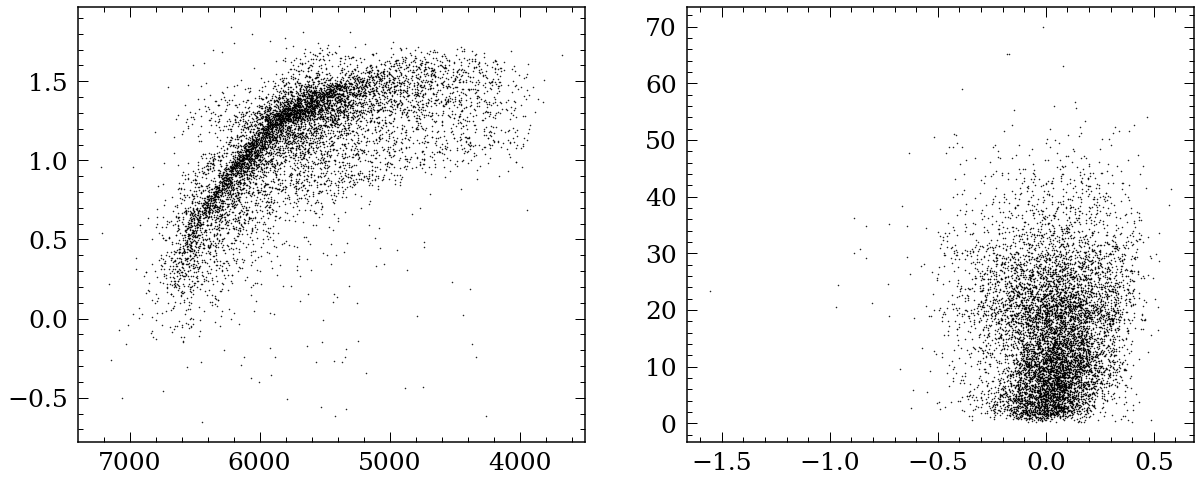

In [30]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(df['Teff'], np.log10(df['Prot']), 'k.', markersize=1)
plt.gca().invert_xaxis()
plt.subplot(1,2,2)
plt.plot(df['feh'], df['Prot'], 'k.', markersize=1)



In [31]:
ASstars = pd.read_csv('ASage.csv') 
from astropy.io import ascii
ASstars_feh = ascii.read('ASfeh.txt').to_pandas()

ASstars = pd.merge(ASstars, ASstars_feh[['KIC','[Fe/H]']],
                  left_on='KIC',right_on='KIC')
ASstars

,Pipe,KIC,Mass,Rad,log(g),Age,Lum,rho,Dist,Xini,Yini,Xsup,Ysup,Xcen,Ycen,MCcore,Rbce,alpha,TAMS,[Fe/H]
0,AST,1435467,1.3417,1.7029,4.1028,2.6679,4.2160,0.382500,137.22,0.7020,0.2780,0.7020,0.2780,0.1160,0.8640,0.0590,0.8410,1.8000,2.9535,0.01
1,BASTA,1435467,1.3189,1.6925,4.0997,3.0164,4.0630,0.383008,136.37,0.7080,0.2740,0.7080,0.2740,0.1260,0.8550,0.0600,0.8280,1.7910,3.4084,0.01
2,C2kSMO,1435467,1.3944,1.7039,4.1192,1.9347,4.3110,0.397100,137.31,0.6580,0.3100,0.7820,0.1940,0.3640,0.6030,0.1240,0.8600,0.6480,3.2265,0.01
3,GOE,1435467,1.3146,1.6816,4.1052,1.8084,4.1801,0.389424,135.50,0.6035,0.3632,0.7116,0.2640,NaN,NaN,NaN,NaN,1.7975,2.6348,0.01
4,V&A,1435467,1.3920,1.7070,4.1182,2.6940,4.0550,0.395238,137.56,0.7290,0.2500,0.7290,0.2500,0.2920,0.6870,0.0670,0.8760,1.9900,9.9999,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,BASTA,12317678,1.3379,1.8154,4.0480,2.4574,5.6490,0.316265,143.50,0.7240,0.2650,0.7240,0.2650,0.0940,0.8960,0.0590,0.9030,1.7910,2.6799,-0.28
392,C2kSMO,12317678,1.3199,1.7187,4.0879,2.9709,4.9720,0.366200,135.92,0.7370,0.2510,0.8230,0.1670,0.2000,0.7890,0.0970,0.8340,0.8620,3.5096,-0.28
393,GOE,12317678,1.5196,1.8756,4.0733,1.1773,6.8050,0.324411,148.30,0.6147,0.3470,0.7989,0.1813,NaN,NaN,NaN,NaN,2.1989,1.2553,-0.28
394,V&A,12317678,1.1920,1.7510,4.0276,3.4410,4.7590,0.313150,138.38,0.6890,0.2970,0.8030,0.1880,0.0020,0.9850,0.0160,0.8830,1.5100,9.9999,-0.28


In [32]:
ASKICs = ASstars['KIC'].unique()
ASage = np.zeros(len(ASKICs))
ASage_err = np.zeros(len(ASKICs))
ASfeh = np.zeros(len(ASKICs))
for i in range(len(ASKICs)):
    singstar = ASstars.loc[ASstars['KIC']==ASKICs[i]]
    ASage_err[i] = np.std(singstar['Age'])
    ASage[i] = np.mean(singstar['Age'])
    ASfeh[i] = singstar['[Fe/H]'].values[0]
ASages = pd.DataFrame(np.array((ASKICs, ASage, ASage_err, ASfeh)).T, columns=['KIC','Age','Age_err','[Fe/H]'])
ASages = pd.merge(ASages, df, left_on='KIC', right_on='KIC', how='inner')
ASages = ASages.loc[ASages['Ro']<2].reset_index(drop=True)

print(len(ASages))


13


In [34]:
ASages['Prot_log'] = np.log10(ASages['Prot'])

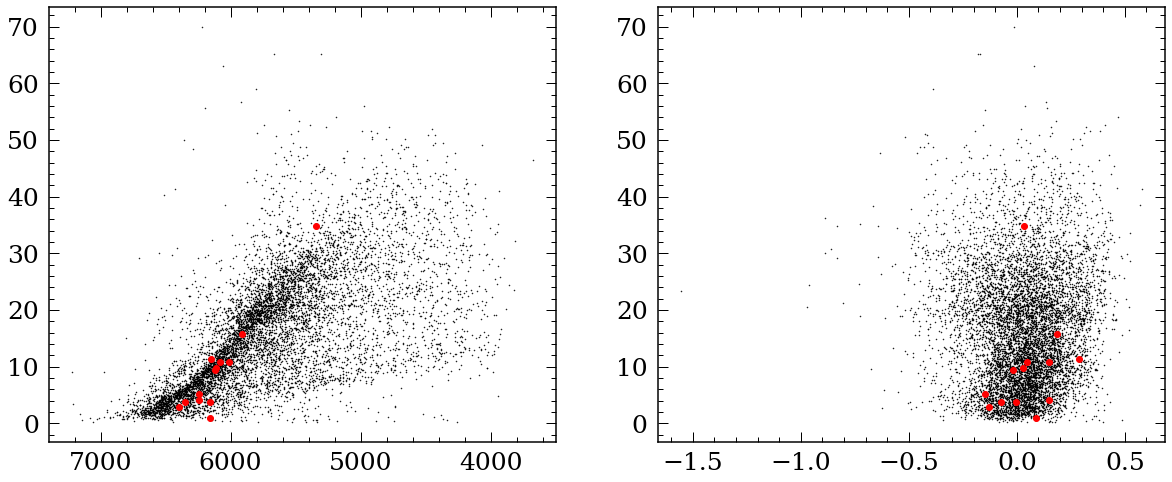

In [35]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(df['Teff'], df['Prot'], 'k.', markersize=1)
plt.plot(ASages['Teff'], ASages['Prot'], 'ro')
plt.gca().invert_xaxis()

plt.subplot(1,2,2)
plt.plot(df['feh'], df['Prot'], 'k.', markersize=1)
plt.plot(ASages['feh'], ASages['Prot'], 'ro')



In [36]:
df['Prot_log'] = np.log10(df['Prot'])


In [37]:
df['vz'] = np.array(df['vz'], dtype=float)

In [38]:
ASages = ASages.reset_index(drop=True)


In [43]:
ASages

,KIC,Age,Age_err,[Fe/H],source_id,Prot,mass,Teff,feh,Ro,vz,Prot_log,vel_dis,kin_age
0,2837475.0,1.422017,0.469352,0.01,2099526837747055232,3.730000,1.289065,6349.4893,-0.005958,0.838566,-5.556281,0.571709,8.550056,1.787390
1,3735871.0,1.834100,0.276317,-0.04,2099574421688108928,10.760000,1.083938,6084.4126,0.047636,0.818620,12.684770,1.031812,7.905343,1.579754
2,5773345.0,2.444133,0.451752,0.21,2103850667224606720,11.290000,1.484401,6150.2896,0.289850,1.595980,-8.912669,1.052694,14.896706,4.285614
3,6508366.0,2.035017,0.349360,-0.05,2102432743901009280,3.720000,1.419695,6160.7207,-0.071029,0.949366,10.969306,0.570543,12.171670,3.117543
4,7206837.0,2.341300,0.590154,0.10,2077773790469159680,4.072000,1.369463,6241.0186,0.150150,1.602178,-10.441764,0.609808,10.395516,2.431703
5,8150065.0,3.635633,0.358206,-0.13,2105943072207122688,9.700000,1.201296,6114.3580,0.028032,1.779546,-6.165849,0.986772,7.967962,1.599509
6,9812850.0,2.493683,0.256461,-0.07,2119147279145539584,5.170000,1.281489,6238.8190,-0.145390,1.302579,8.310390,0.713491,9.293815,2.038347
7,9955598.0,6.680900,0.261870,0.05,2128215909315876352,34.810001,0.930000,5343.7085,0.035436,1.196392,-0.634151,1.541704,NaN,NaN
8,10079226.0,2.799083,0.178390,0.11,2128409045404259328,15.694000,1.101870,5913.8310,0.185770,0.979460,-13.631167,1.195734,15.266360,4.454312
9,10644253.0,1.287300,0.500790,0.06,2119828460957942528,10.880000,1.200520,6012.8286,0.147130,0.980858,10.313527,1.036629,9.411672,2.079210


In [44]:
def optimizeBins(df,df_match,fs,binmin,binmax,min_star=5,max_star=30,df_match_name='age',df_match_name_err='age_err',vz='v_b',bintestNo=10,errVals=False):

    df=df.dropna(subset=np.append([vz],fs)).reset_index(drop=True)
    p_mp, p_mr, p_a = get_avr_coefficients()
    
    df=df.reset_index(drop=True)
    
    
    fslen=len(fs)
    dflen=len(df_match)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((len(df),fslen))
    paras_match=np.zeros((len(df_match),fslen))
    agecomp = df_match[df_match_name].values
    agecomp_err = df_match[df_match_name_err].values
   
            
    for i in range(fslen):
        #print(fs[i], np.shape(df[fs[i]].values), df[fs[i]].values[0])
        paras[:,i]=df[fs[i]].values
        paras_match[:,i]=df_match[fs[i]].values
    
    
    vels=df[vz].values
    kin_age=np.zeros(len(df_match))
    No_stars=np.zeros(len(df_match))
    
    binfs=np.zeros((fslen,bintestNo))
    
    for k in range(fslen):
        binfs[k,:]=np.linspace(binmin[k],binmax[k],bintestNo)
    
    
    testbins=[]
    
    sums=''
    a=['i'+str(i)+',' for i in range(fslen)]
    for i in a:
        sums=sums+i
    
    for a in product(range(bintestNo), repeat=len(a)):
        evalint=[binfs[j,a[j]] for j in range(len(a))]
        testbins.append(evalint)

    
    # optimization
    count=0
    
    for k in trange(len(testbins)):
        binfs=testbins[k]
        for i in range(len(df_match)):
            mask=np.ones(len(df), dtype=bool)
        
            for j in range(fslen):
                checkpara[j]=paras_match[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2.)
            vels_single=vels[mask]
            
            binfs_new=binfs
        
            
            while len(vels_single)<min_star:
                if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
                binfs_new=[ii*1.1 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras_match[i,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
                
            while len(vels_single)>max_star:
                if any([binfs_new[jj]<binfs[jj]/2 for jj in range(len(binfs))]):
                    break
                binfs_new=[ii*0.9 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras_match[i,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
            
            kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
            No_stars[i]=len(vels_single)
        
        
        kinages = v_to_age(kin_age,p_a)
        m = (kinages!=kinages)
        kinages[m] = -999
        
        if count==0:
            chisq=sum(((agecomp-kinages)**2./np.power(agecomp_err,2.)))/len(df_match)
            age_best=kinages
            opt_binsize=binfs
            count=count+1
        else:
            chisq_new=sum(((agecomp-kinages)**2./np.power(agecomp_err,2.)))/len(df_match)
            if chisq_new<chisq:
                opt_binsize=binfs
                chisq=chisq_new
                age_best=kinages
            count=count+1
        
    return opt_binsize, agecomp, age_best, chisq



# bin in 'Teff','Prot_log','feh','Ro'

In [45]:
#df['Ro'] = df['Prot']/df['Ro']
df = df.dropna(subset=['Teff','Prot_log','feh','Ro']).reset_index(drop=True)

opt_binsize, agecomp, kinages, chisq = optimizeBins(df,ASages,
                                                    ['Teff','Prot_log','feh'],
                                             [50,0.05,0.01,0.01],[200,0.5,0.1],
                                             min_star=10,max_star=50000,
                                                    df_match_name='Age',
                                             df_match_name_err='Age_err',vz='vz',
                                             bintestNo=50,errVals=True)

  0%|          | 0/125000 [00:00<?, ?it/s]<ipython-input-1-080acc689b70>:50: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
100%|██████████| 125000/125000 [04:26<00:00, 469.34it/s]


[83.67346938775509, 0.30714285714285716, 0.06877551020408164] 2.8235115357076745
-0.15274043690997846 0.6755844273710107


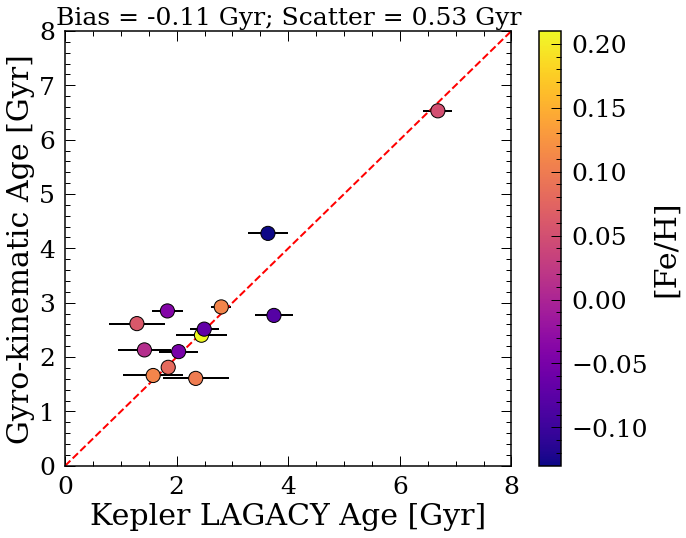

In [46]:
plt.figure(figsize=(10,8))
plt.errorbar(agecomp, kinages, xerr=ASages['Age_err'], 
             fmt='k.', markersize=10, zorder=1)

plt.scatter(agecomp, kinages, c=ASages['[Fe/H]'], 
             cmap='plasma', s=200, zorder=10, edgecolor='k')

plt.colorbar(label='[Fe/H]')
plt.plot([0,13],[0,13],'r--')
plt.xlim([0,8])
plt.ylim([0,8])
plt.xlabel('Kepler LAGACY Age [Gyr]')
plt.ylabel('Gyro-kinematic Age [Gyr]')
print(opt_binsize, chisq)
m = ASages['[Fe/H]']<0
print(np.mean(agecomp[m]-kinages[m]), np.std(agecomp[m]-kinages[m]))
plt.title('Bias = -0.11 Gyr; Scatter = 0.53 Gyr', fontsize=25)
plt.savefig('./VictorFigure/age_optimize')

In [47]:
"""
pd.DataFrame(np.array((agecomp, kinages, ASages['Age_err'].values, ASages['[Fe/H]'].values)).T,
            columns=['TrueAge','kinage','TrueAge_err','feh']).to_csv('comparison.csv',index=False)
"""

"\npd.DataFrame(np.array((agecomp, kinages, ASages['Age_err'].values, ASages['[Fe/H]'].values)).T,\n            columns=['TrueAge','kinage','TrueAge_err','feh']).to_csv('comparison.csv',index=False)\n"

In [48]:

df['vel_dis'],df['kin_age']=getkinAges(df,['Teff','Prot_log','feh'],
                                              opt_binsize,vz='vz',min_star=10,
                                               max_star=50000)




100%|██████████| 8351/8351 [00:01<00:00, 5816.77it/s]

2813



<ipython-input-1-080acc689b70>:50: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


In [49]:
df['kin_age'].dropna()

0       8.641323
1       4.377098
2       5.234514
3       1.437025
4       1.163319
          ...   
8343    3.262057
8344    2.278372
8345    3.373407
8346    1.486139
8347    0.870086
Name: kin_age, Length: 8296, dtype: float64

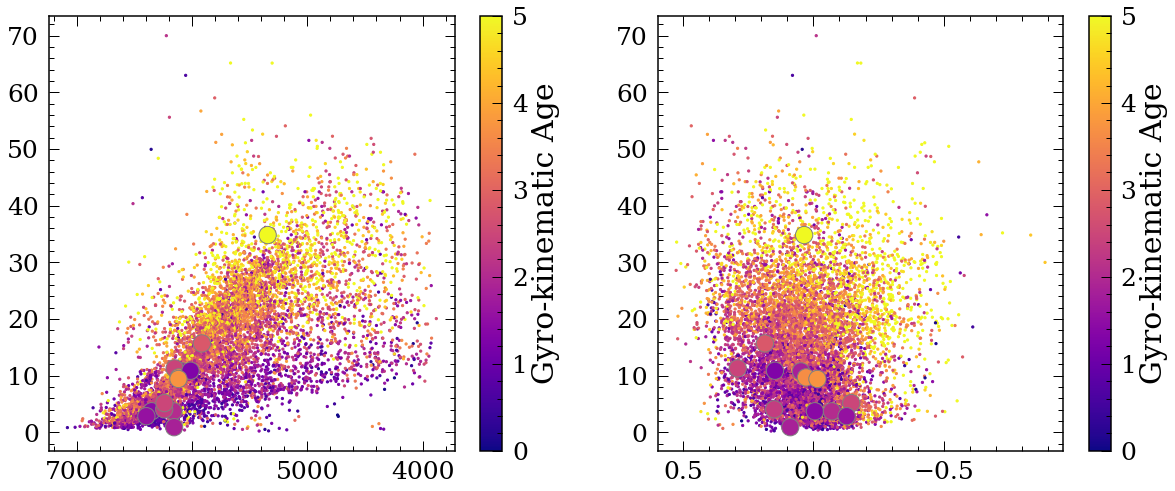

In [50]:
agemax = 5
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(df['Teff'], df['Prot'], c=df['kin_age'], s=5,
           vmin=0, vmax=agemax, cmap=plt.get_cmap('plasma'))
plt.colorbar(label='Gyro-kinematic Age')
plt.scatter(ASages['Teff'], ASages['Prot'], c=ASages['Age'],
            vmin=0, vmax=agemax, edgecolor='grey', s=300, 
            cmap=plt.get_cmap('plasma'))
plt.gca().invert_xaxis()

plt.subplot(1,2,2)
plt.scatter(df['feh'], df['Prot'], c=df['kin_age'], s=5,
           vmin=0, vmax=agemax, cmap=plt.get_cmap('plasma'))
plt.colorbar(label='Gyro-kinematic Age')
plt.scatter(ASages['feh'], ASages['Prot'], c=ASages['Age'],
            vmin=0, vmax=agemax,edgecolor='grey', s=300, 
            cmap=plt.get_cmap('plasma'))
plt.gca().invert_xaxis()






Text(0.5, 1.0, 'Bin by $T_\\mathrm{eff}$, $P_\\mathrm{rot}$, [Fe/H] = [83.67, 0.31, 0.07]\n $M$-$M_\\odot$ < 0.1 $M_\\odot$')

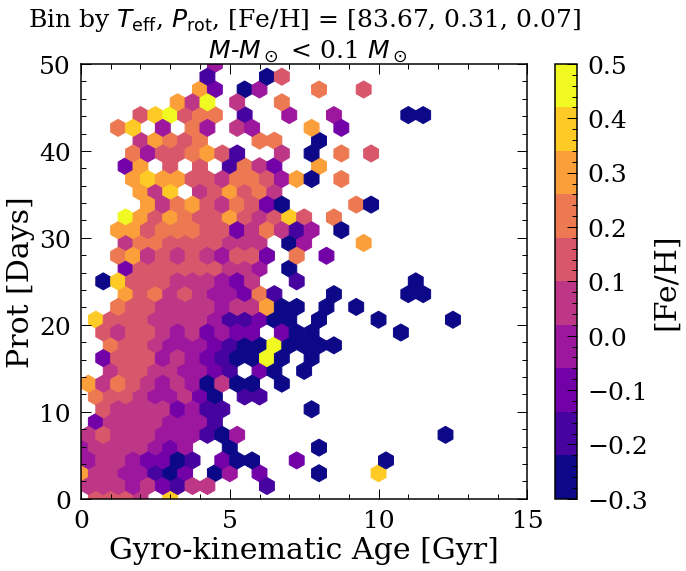

In [51]:
plt.figure(figsize=(10,8))
m = (abs(df['mass']-1)<0.1)

"""plt.scatter(df['kin_age'], df['Prot'], c=df['feh'],
            vmin=-0.5,vmax=0.5,cmap=plt.get_cmap('plasma', 10))"""
plt.hexbin(df['kin_age'][m], df['Prot'][m], C=df['feh'][m],
            vmin=-0.3,vmax=0.5,cmap=plt.get_cmap('plasma', 10),
          extent=(0,15,0,50), gridsize=30)
cb = plt.colorbar()
cb.set_label('[Fe/H]')
plt.xlabel('Gyro-kinematic Age [Gyr]')
plt.ylabel('Prot [Days]')
#plt.yscale('log')
plt.xlim([0,15])
plt.ylim([0,50])
#plt.vlines(3450,ymax=150,ymin=10,color='r')
#plt.vlines(3400,ymax=150,ymin=10,color='r')

plt.title('Bin by $T_\mathrm{eff}$, $P_\mathrm{rot}$, [Fe/H] = [%.2f, %.2f, %.2f]\n $M$-$M_\odot$ < 0.1 $M_\odot$'%(opt_binsize[0], 
                opt_binsize[1], opt_binsize[2]), 
         fontsize=25)

In [52]:
"""plt.plot(df['Teff'], df['feh'], 'ko')"""

"plt.plot(df['Teff'], df['feh'], 'ko')"

Text(0, 0.5, 'Prot')

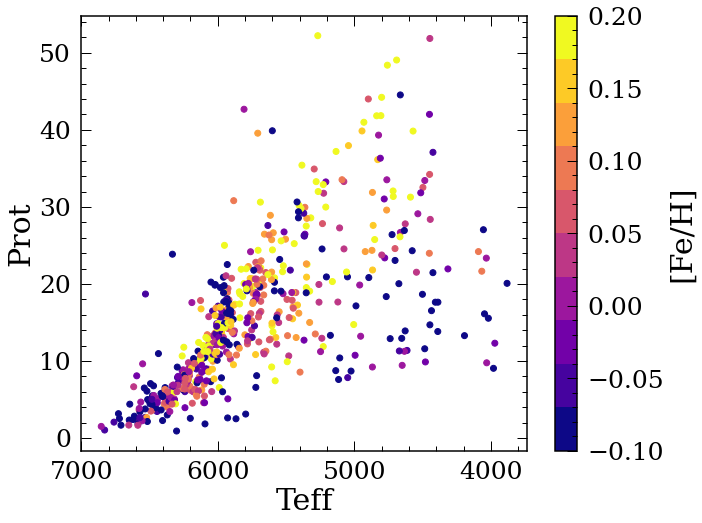

In [53]:
import scipy
ageplot = 2.7

m = abs(df['kin_age']-ageplot)<0.1
plt.figure(figsize=(10,8))
"""plt.hexbin(df['Teff'][m], df['Prot'][m], C=df['feh'][m], 
           cmap=plt.get_cmap('plasma',10),
          gridsize=40,vmin=-0.1,vmax=0.2)"""

plt.scatter(df['Teff'][m], df['Prot'][m], c=df['feh'][m], 
           cmap=plt.get_cmap('plasma',10),
          vmin=-0.1,vmax=0.2)

df = df.sort_values(by='Teff').reset_index(drop=True)
Mrange = np.linspace(-0.3, 0.5, 5)
colors = getcolor(range(len(Mrange)+1))
for i in range(len(Mrange)):
    m2 = (df['feh'][m]>Mrange[i]-0.05)&(df['feh'][m]<Mrange[i]+0.05)
    r_age, r_omega = scipy.ndimage.gaussian_filter1d((df['Teff'][m][m2], 
                                    df['Prot'][m][m2]),5)
    m3 = (r_age!=0)
    #plt.plot(r_age[m3], r_omega[m3], '-', color=colors[i])



plt.colorbar(label='[Fe/H]')
plt.gca().invert_xaxis()
plt.xlabel('Teff') 
plt.ylabel('Prot')


In [54]:
df['kin_age_teff'] = df['kin_age']

# bin in 'M','Prot_log','feh','Ro'


  0%|          | 0/125000 [00:00<?, ?it/s]<ipython-input-1-080acc689b70>:50: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
100%|██████████| 125000/125000 [03:52<00:00, 538.56it/s]


([0.05, 0.30714285714285716, 0.07061224489795918], 1.6216850867110644)

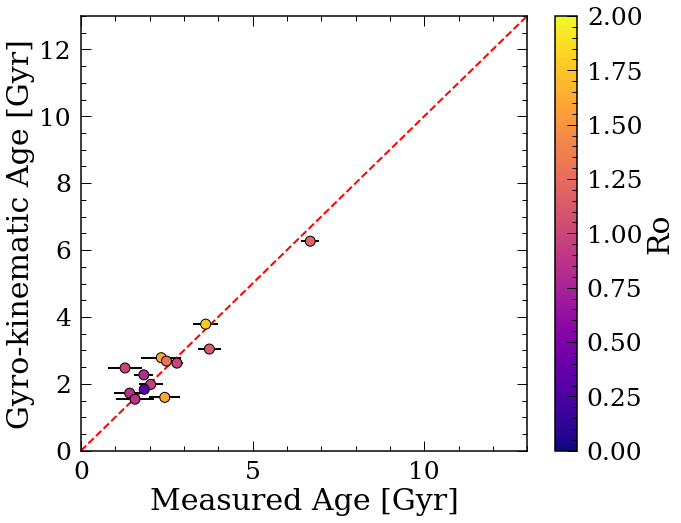

In [55]:

df = df.dropna(subset=['mass','Prot_log','feh','Ro']).reset_index(drop=True)

opt_binsize, agecomp, kinages, chisq = optimizeBins(df,ASages,
                                                    ['mass','Prot_log','feh'],
                                             [0.01,0.05,0.01],[0.5,0.5,0.1],
                                             min_star=10,max_star=50000,
                                                    df_match_name='Age',
                                             df_match_name_err='Age_err',vz='vz',
                                             bintestNo=50,errVals=True)




plt.figure(figsize=(10,8))
plt.errorbar(agecomp, kinages, xerr=ASages['Age_err'], 
             fmt='k.', markersize=10, zorder=1)

plt.scatter(agecomp, kinages, c=ASages['Ro'], 
             cmap='plasma', s=100, zorder=10, edgecolor='k',
           vmin=0, vmax=2)

plt.colorbar(label='Ro')
plt.plot([0,13],[0,13],'r--')
plt.xlim([0,13])
plt.ylim([0,13])
plt.xlabel('Measured Age [Gyr]')
plt.ylabel('Gyro-kinematic Age [Gyr]')

opt_binsize, chisq



In [56]:
df['vel_dis'],df['kin_age']=getkinAges(df,['mass','Prot_log','feh'],
                                              opt_binsize,vz='vz',min_star=10,
                                               max_star=50000)





100%|██████████| 8351/8351 [00:00<00:00, 8507.94it/s]

1602



<ipython-input-1-080acc689b70>:50: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


In [57]:
df['kin_age'].dropna()

4       0.439134
6       2.588780
7       3.234310
8       2.189344
9       5.023662
          ...   
8346    3.012898
8347    1.389844
8348    1.572426
8349    1.931592
8350    1.598687
Name: kin_age, Length: 8319, dtype: float64

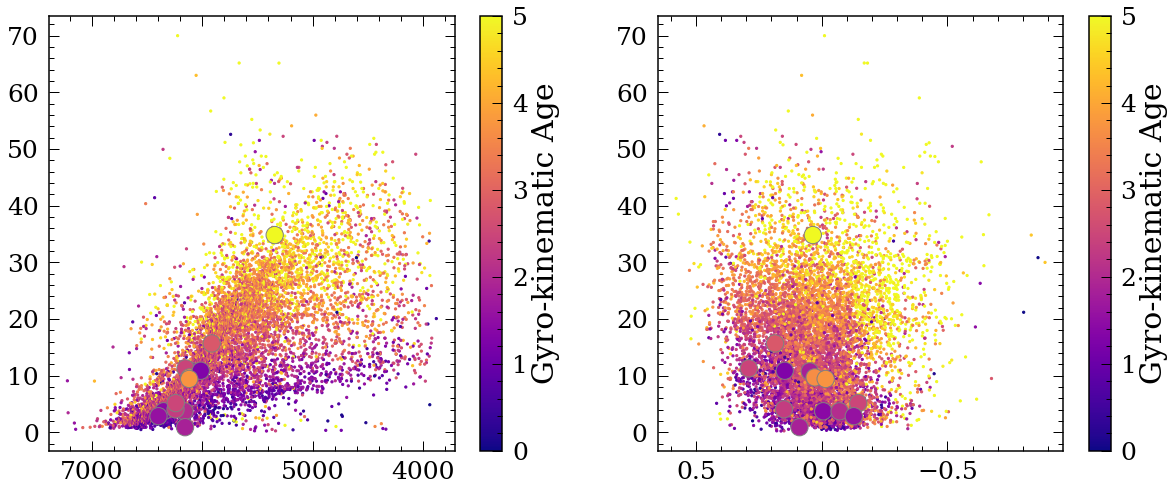

In [58]:
agemax = 5
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(df['Teff'], df['Prot'], c=df['kin_age'], s=5,
           vmin=0, vmax=agemax, cmap=plt.get_cmap('plasma'))
plt.colorbar(label='Gyro-kinematic Age')
plt.scatter(ASages['Teff'], ASages['Prot'], c=ASages['Age'],
            vmin=0, vmax=agemax, edgecolor='grey', s=300, 
            cmap=plt.get_cmap('plasma'))
plt.gca().invert_xaxis()

plt.subplot(1,2,2)
plt.scatter(df['feh'], df['Prot'], c=df['kin_age'], s=5,
           vmin=0, vmax=agemax, cmap=plt.get_cmap('plasma'))
plt.colorbar(label='Gyro-kinematic Age')
plt.scatter(ASages['feh'], ASages['Prot'], c=ASages['Age'],
            vmin=0, vmax=agemax,edgecolor='grey', s=300, 
            cmap=plt.get_cmap('plasma'))
plt.gca().invert_xaxis()







3636


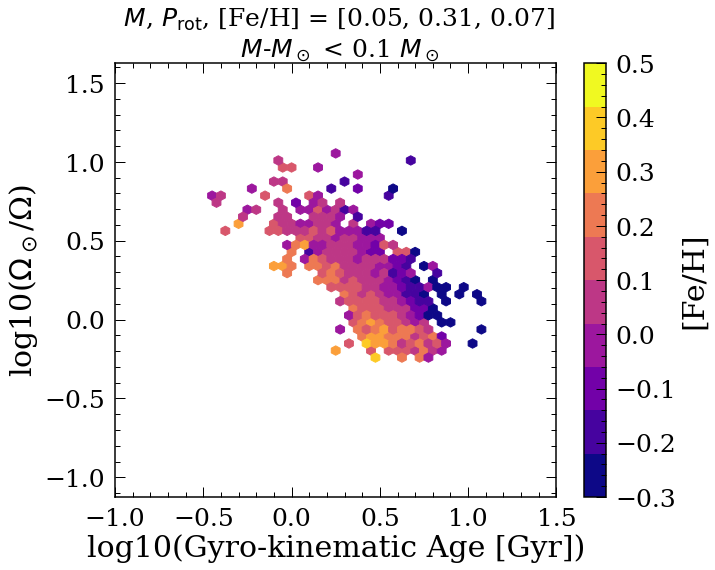

In [59]:
plt.figure(figsize=(10,8))
m = (abs(df['mass']-1)<0.1)
print(sum(m))

"""plt.scatter(df['kin_age'], df['Prot'], c=df['feh'],
            vmin=-0.5,vmax=0.5,cmap=plt.get_cmap('plasma', 10))"""
"""plt.hexbin(df['kin_age'][m], df['Prot'][m], C=df['feh'][m],
            vmin=-0.3,vmax=0.5,cmap=plt.get_cmap('plasma', 10),
          extent=(0,15,0,50), gridsize=30)"""

"""plt.scatter(np.log10(df['kin_age'][m]), np.log10(27/df['Prot'][m]), 
            c=df['feh'][m],s=2,
            vmin=-0.3,vmax=0.5,cmap=plt.get_cmap('plasma', 10))"""

plt.hexbin(np.log10(df['kin_age'][m]), np.log10(27/df['Prot'][m]), 
           C=df['feh'][m], vmin=-0.3,vmax=0.5,cmap=plt.get_cmap('plasma', 10),
          extent=(-1,1.5,-1,1.5), gridsize=50, mincnt=1)

df = df.sort_values(by='kin_age').reset_index(drop=True)
Mrange = np.linspace(-0.3, 0.5, 5)
    
cb = plt.colorbar()
cb.set_label('[Fe/H]')
plt.xlabel('log10(Gyro-kinematic Age [Gyr])')
plt.ylabel('log10($Ω_\odot$/Ω)')
#plt.yscale('log')
#plt.xlim([0,15])
#plt.ylim([0,50])
plt.xlim([-1,1.5])

plt.title(' $M$, $P_\mathrm{rot}$, [Fe/H] = [%.2f, %.2f, %.2f]\n $M$-$M_\odot$ < 0.1 $M_\odot$'%(opt_binsize[0], 
                opt_binsize[1], opt_binsize[2]), 
         fontsize=25)
plt.tight_layout()

In [60]:
(1/(0.85))**-0.5, (1/(1.15))**-0.5

(0.9219544457292888, 1.0723805294763609)

3636


/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in doubl

"cb = plt.colorbar()\ncb.set_label('[Fe/H]')\nplt.xlabel('log10(Gyro-kinematic Age [Gyr])')\nplt.ylabel('log10($Ω_\\odot$/Ω)')\n#plt.yscale('log')\n#plt.xlim([0,15])\n#plt.ylim([0,50])\nplt.xlim([-1,1.5])\n\nplt.title(' $M$, $P_\\mathrm{rot}$, [Fe/H], $τ_c$ = [%.2f, %.2f, %.2f, %.2f]\n $M$-$M_\\odot$ < 0.1 $M_\\odot$'%(opt_binsize[0], \n                opt_binsize[1], opt_binsize[2],opt_binsize[3]), \n         fontsize=25)\nplt.tight_layout()"

<Figure size 720x576 with 0 Axes>

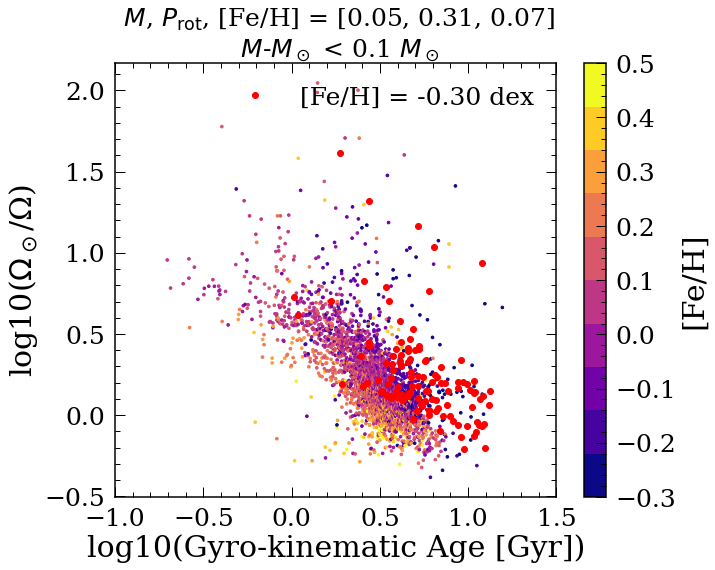

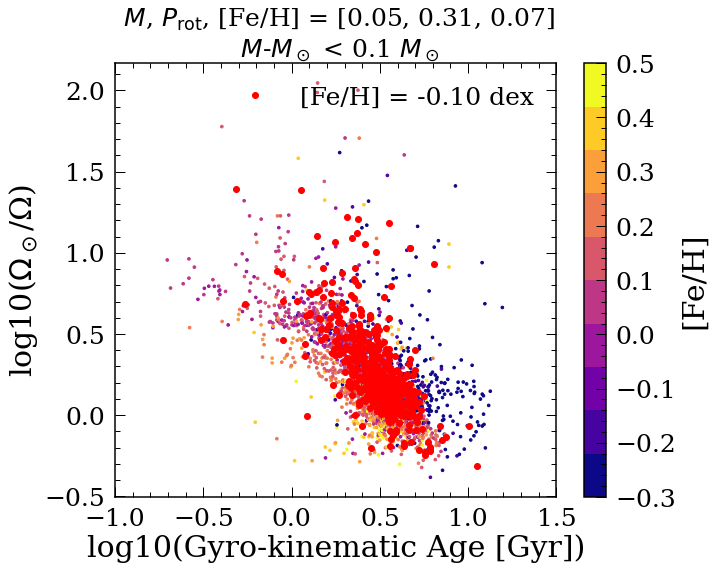

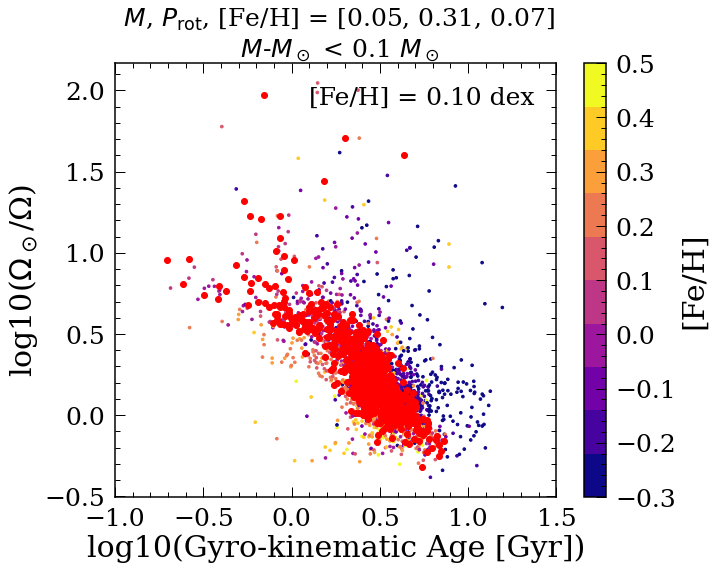

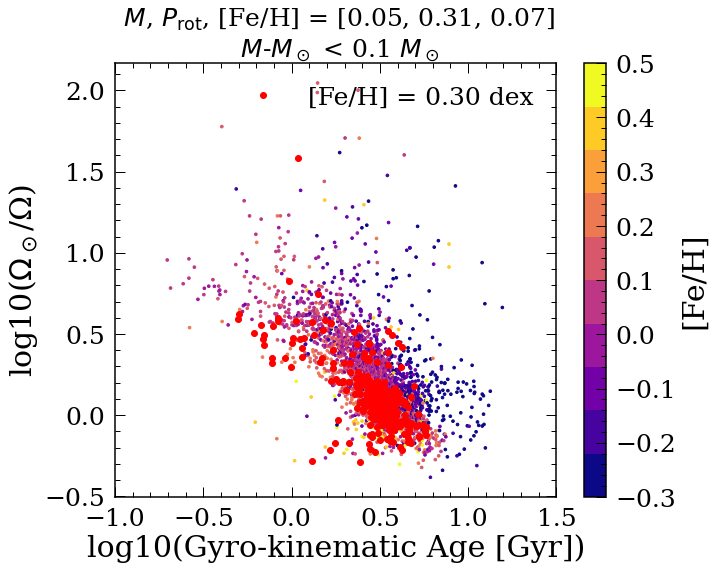

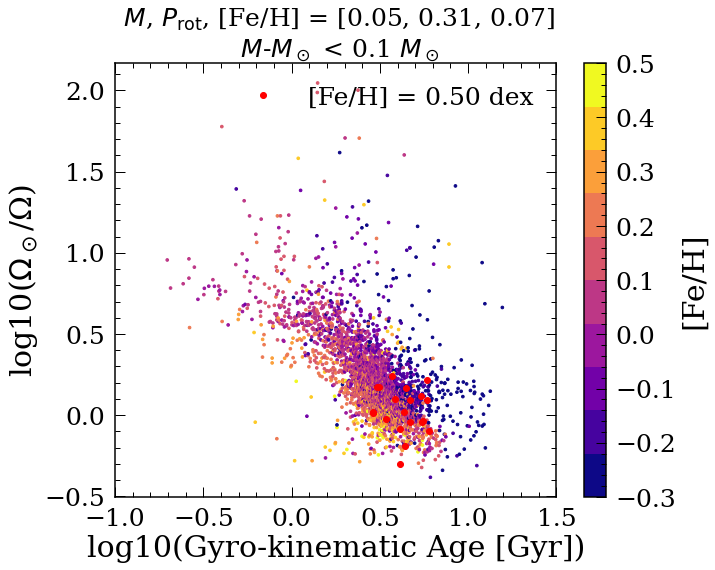

In [61]:
plt.figure(figsize=(10,8))
m = (abs(df['mass']-1)<0.1)
print(sum(m))

"""plt.scatter(df['kin_age'], df['Prot'], c=df['feh'],
            vmin=-0.5,vmax=0.5,cmap=plt.get_cmap('plasma', 10))"""
"""plt.hexbin(df['kin_age'][m], df['Prot'][m], C=df['feh'][m],
            vmin=-0.3,vmax=0.5,cmap=plt.get_cmap('plasma', 10),
          extent=(0,15,0,50), gridsize=30)"""

"""plt.scatter(np.log10(df['kin_age'][m]), np.log10(27/df['Prot'][m]), 
            c=df['feh'][m],s=7,
            vmin=-0.3,vmax=0.5,cmap=plt.get_cmap('plasma', 10))"""

df = df.sort_values(by='kin_age').reset_index(drop=True)
Mrange = np.linspace(-0.3, 0.5, 5)
colors = getcolor(range(len(Mrange)+1))
for i in range(len(Mrange)):
    plt.figure(figsize=(10,8))
    plt.scatter(np.log10(df['kin_age'][m]), np.log10(27/df['Prot'][m]), 
            c=df['feh'][m],s=7,
            vmin=-0.3,vmax=0.5,cmap=plt.get_cmap('plasma', 10))
    m2 = (df['feh'][m]>Mrange[i]-0.05)&(df['feh'][m]<Mrange[i]+0.05)
    r_age, r_omega = movingMed_time(np.log10(df['kin_age'][m])[m2], 
                                    np.log10(27/df['Prot'][m])[m2],
                                   0.5,0.3)
    m3 = (r_age!=0)
    #plt.plot(r_age[m3], r_omega[m3], '-o', color=colors[i])
    plt.plot(np.log10(df['kin_age'][m])[m2], 
                np.log10(27/df['Prot'][m])[m2],'ro',
            label='[Fe/H] = %.2f dex'%Mrange[i])
    
    cb = plt.colorbar()
    cb.set_label('[Fe/H]')
    plt.xlabel('log10(Gyro-kinematic Age [Gyr])')
    plt.ylabel('log10($Ω_\odot$/Ω)')
    #plt.yscale('log')
    #plt.xlim([0,15])
    #plt.ylim([0,50])
    plt.xlim([-1,1.5])

    plt.title(' $M$, $P_\mathrm{rot}$, [Fe/H] = [%.2f, %.2f, %.2f]\n $M$-$M_\odot$ < 0.1 $M_\odot$'%(opt_binsize[0], 
                    opt_binsize[1], opt_binsize[2]), 
             fontsize=25)
    plt.legend()
    plt.tight_layout()

"""cb = plt.colorbar()
cb.set_label('[Fe/H]')
plt.xlabel('log10(Gyro-kinematic Age [Gyr])')
plt.ylabel('log10($Ω_\odot$/Ω)')
#plt.yscale('log')
#plt.xlim([0,15])
#plt.ylim([0,50])
plt.xlim([-1,1.5])

plt.title(' $M$, $P_\mathrm{rot}$, [Fe/H], $τ_c$ = [%.2f, %.2f, %.2f, %.2f]\n $M$-$M_\odot$ < 0.1 $M_\odot$'%(opt_binsize[0], 
                opt_binsize[1], opt_binsize[2],opt_binsize[3]), 
         fontsize=25)
plt.tight_layout()"""

In [62]:
df['kin_age_mass'] = df['kin_age']

In [63]:
df.dropna().to_csv('Victor_gyroage.csv', index=False)

In [64]:
df.dropna()

,KIC,source_id,Prot,mass,Teff,feh,Ro,vz,Prot_log,vel_dis,kin_age,kin_age_teff,kin_age_mass
2,6130409.0,2077417303879747712,2.031000,1.051618,5713.3800,0.275000,0.079845,-0.886973,0.307710,0.219464,0.020380,0.020380,0.020380
4,5597406.0,2104345069498052864,3.070000,0.764180,4737.3300,-0.062000,0.059692,1.373469,0.487138,0.702097,0.085718,0.037252,0.085718
5,10285091.0,2080604654952903296,10.350000,1.134294,6411.2700,-0.447000,4.202901,37.564528,1.014940,1.047098,0.140444,13.283449,0.140444
8,11018874.0,2131900170918940160,0.994000,1.151153,6216.7305,-0.070027,0.123662,-1.872920,-0.002614,1.134206,0.155015,1.437025,0.155015
9,4994506.0,2100727882401602944,2.989000,1.031108,5809.3600,0.056000,0.135335,-0.334717,0.475526,1.381333,0.197753,0.716922,0.197753
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8313,9894331.0,2128376167434768512,34.459999,0.760895,5458.8600,-0.557000,1.044439,12.486353,1.537315,45.486734,14.817844,0.483589,14.817844
8314,8935737.0,2106809281214343168,47.730000,0.807650,4712.1500,-0.464000,1.105682,13.759042,1.678791,45.987101,15.019458,5.581423,15.019458
8315,9674789.0,2085336128367139712,22.270000,0.782185,4968.9600,-0.409000,0.636901,-51.799704,1.347720,45.987101,15.019458,6.854256,15.019458
8316,10141400.0,2129114352053619456,30.042999,0.772573,5160.6500,-0.427000,0.898898,41.845447,1.477743,45.987101,15.019458,11.476226,15.019458


0.6419201292708349


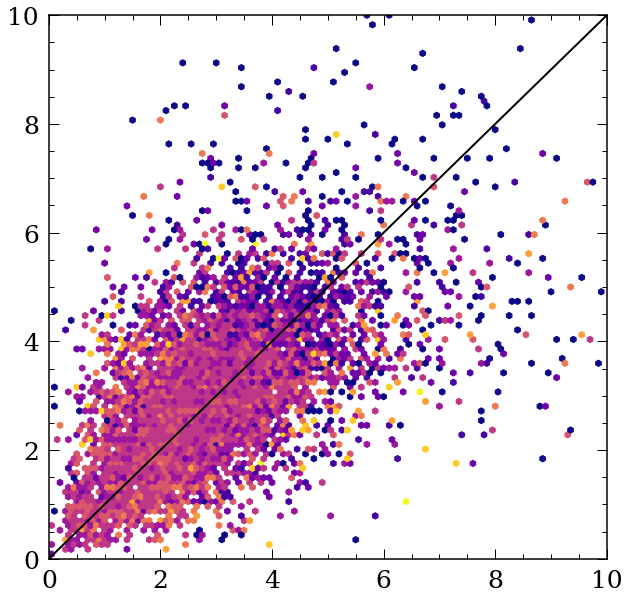

In [65]:
#plt.scatter(df['kin_age_teff'],df['kin_age_mass'],
#           c=df['feh'],s=10, vmin=-0.3, vmax=0.5)

plt.hexbin(df['kin_age_teff'],df['kin_age_mass'],
           C=df['feh'],extent=(0,10,0,10), vmin=-0.3, vmax=0.5,
          cmap=plt.get_cmap('plasma',10))

plt.xlim([0,10])
plt.ylim([0,10])
plt.plot([0,10], [0,10], 'k-')
df = df.dropna(subset=['kin_age_teff','kin_age_mass'])
print(np.median(abs(df['kin_age_teff']-df['kin_age_mass'])))


In [69]:
pwd

'/Users/yl4331/Desktop/NewGyroKineage'

In [3]:
df = pd.read_csv('Victor_gyroage.csv')
df_louis = pd.read_csv('result_Keplernew_LA_all_0722c.csv')

In [6]:
df_louis.columns

Index(['kic', 'mass', 'e_mass', 'z', 'prot', 'e_prot', 'age', 'ep_age',
       'em_age', 'tau_c', 'rad', 'e_rad', 'teff_mod', 'lum', 'e_lum'],
      dtype='object')

In [7]:
df = pd.merge(df, df_louis, left_on='KIC', right_on='kic',
             how='inner')

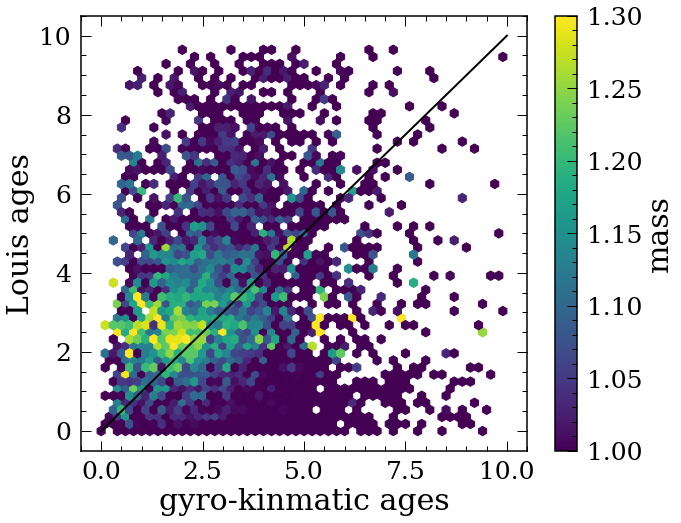

In [38]:
plt.figure(figsize=(10,8))
plt.hexbin(df['kin_age_teff'], df['age'], C=df['mass_x'],
          extent=(0,10,0,10), gridsize=50,
          vmin=1, vmax=1.3)
plt.plot([0,10],[0,10], 'k-')
plt.xlabel('gyro-kinmatic ages')
plt.ylabel('Louis ages')
plt.colorbar(label='mass')

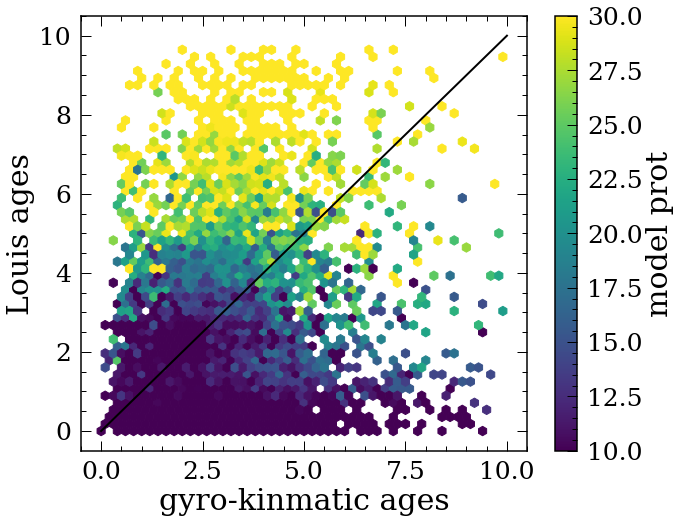

In [49]:
plt.figure(figsize=(10,8))
plt.hexbin(df['kin_age_teff'], df['age'], C=df['prot'],
          extent=(0,10,0,10), gridsize=50,
          vmin=10, vmax=30)
plt.plot([0,10],[0,10], 'k-')
plt.xlabel('gyro-kinmatic ages')
plt.ylabel('Louis ages')
plt.colorbar(label='model prot')

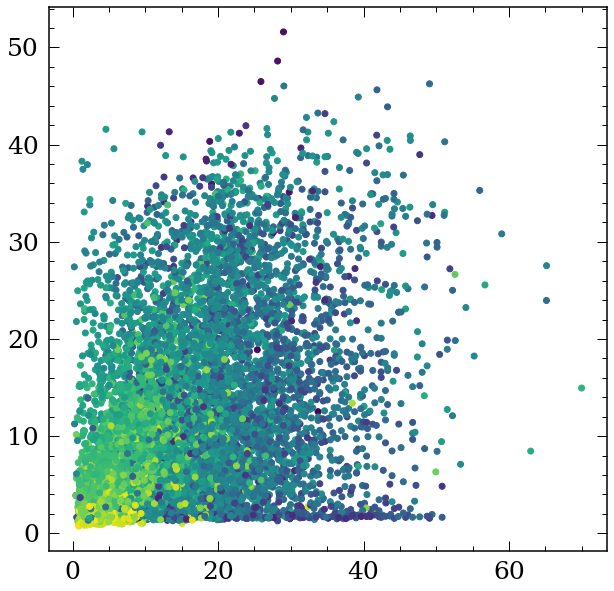

In [17]:
plt.scatter(df['Prot'], df['prot'], c=df['mass_x'])